In [1]:
%load_ext autoreload
%autoreload 2

In [60]:
import torch
import torch.nn as nn
# from dataset import prepare_MNIST
from utils import plot_tensors
import numpy as np

from tqdm.autonotebook import tqdm, trange

# tr, te = prepare_MNIST('../_datasets/', train_batch=1000)
# X, y = next(iter(tr))

X = torch.load('./data/train_data')
X = X[:100]

In [19]:
Xs = torch.split(X, [1000 for i in range(int(10000/1000))])

  0%|          | 0/999 [00:00<?, ?it/s]

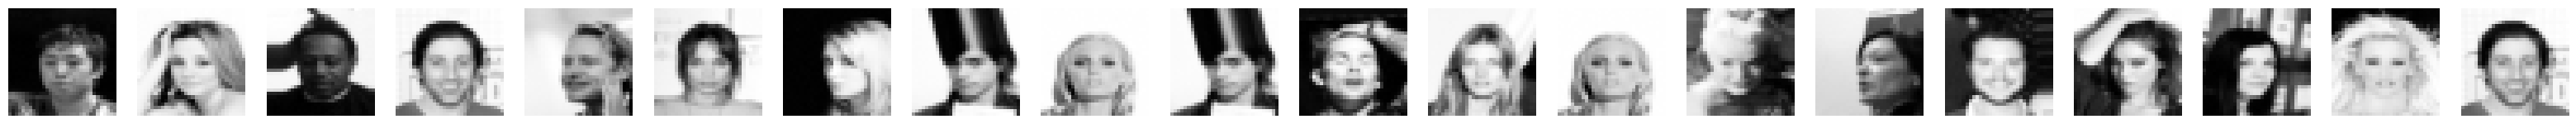

In [208]:
# DDPM
img_size = 32
timesteps = 1000
betas = np.linspace(0.000001, 0.02, timesteps)
alphas = 1. - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
ts = sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)

def DDPM_CF_score(z, t, X):
    w_ = -((z - t * X)**2).sum(dim=[1, 2, 3]) / (2 * (1 - t**2))
    w = torch.softmax(w_, dim=0).view(-1, 1, 1, 1)
    weighted_sum = torch.sum(X * w, dim=0) * t
    score = 1 / (1 - t**2) * (weighted_sum - z)
    return score

def DDPM_CF_score_batch(z, t, X):
    B, C, img_size, _ = z.shape
    K = X.shape[0]
    z_expanded = z.view(B, 1, C, img_size, img_size).expand(-1, K, -1, -1, -1)
    print(z_expanded.shape, X.shape)
    w_ = -((z_expanded - t * X)**2).sum(dim=[i for i in range(2, z.dim()+1)]) / (2 * (1 - t**2))
    # print(w_.shape)
    w = torch.softmax(w_, dim=1).view(B, K, 1, 1, 1)
    # print(w.shape, X.shape)
    weighted_sum = torch.sum(X * w, dim=1) * t
    # print(weighted_sum.shape)
    score = 1 / (1 - t**2) * (weighted_sum - z)
    return score

def DDPM_smoothedCF_score(z, t, X, M=4):
    weighted_sum = torch.zeros_like(z)
    for m in range(M):
        w_ = -((z - t * X)**2 + t*0.2*torch.randn(1)).sum(dim=[1, 2, 3]) / (2 * (1 - t**2))
        w = torch.softmax(w_, dim=0).view(-1, 1, 1, 1)
        weighted_sum = torch.sum(X * w, dim=0) * t
    weighted_sum /= M
    score = 1 / (1 - t**2) * (weighted_sum - z)
    return score

# DDPM sampling

z = torch.randn(20, 1, img_size, img_size)
for t in trange(len(betas)-1, 0, -1, leave=False):
    beta = betas[t]
    s = torch.zeros_like(z)
    # for j in range(len(Xs)):
    #     # XX = Xs[j] + 0.05*torch.randn_like(Xs[j])
    #     s += DDPM_CF_score(z, ts[t], Xs[j])
    # s /= len(Xs)
    s = score_nonparametric(z, torch.tensor(ts[t]).expand(20,), X)
    z = (z + beta * s) / alphas[t] + np.sqrt(beta) * torch.randn_like(z)
plot_tensors(z, 1, 20, 'grey')

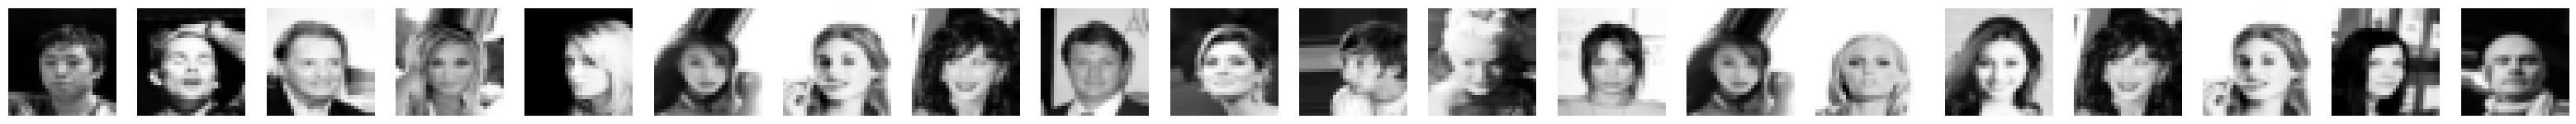

In [205]:
"""
find the nearest neighbour in the training set
"""
neighbours = torch.zeros_like(z)
for i in range(z.size(0)):
    x = z[i]
    d = ((x - X)**2).sum(dim=[1, 2, 3])
    nn_id = torch.argmin(d)
    neighbours[i] = X[nn_id]
plot_tensors(neighbours, 1, z.size(0), 'grey')


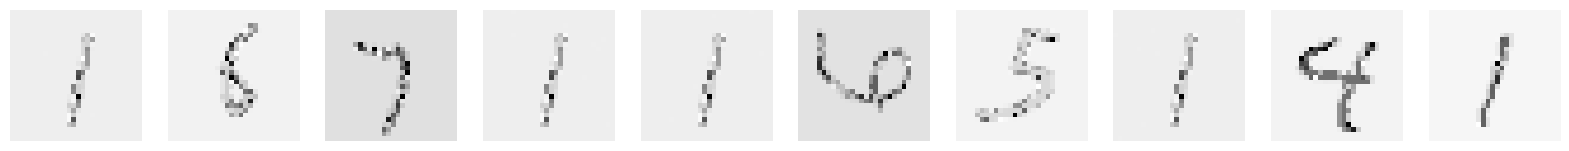

In [680]:
"""
Note that there is some hard interpolation between samples, is this related to the prior hole problem in the case of VAE, that some part is not trained?
"""

def closed_form_score(z, t, X, p=0.):
    w_ = -((z + p * torch.randn_like(z) - t * X)**2).sum(dim=[1, 2, 3]) / (2 * (1 - t)**2)
    w = torch.softmax(w_, dim=0).view(-1, 1, 1, 1)
    # print(w.view(-1,))
    weighted_sum = torch.sum(X * w, dim=0) * t
    score = 1 / (1 - t)**2 * (weighted_sum - z)
    return score

beta = torch.arange(0, 1, 0.005)
stepsize = 1 / len(beta)

X_ = torch.zeros(10, 1, 28, 28)

for j in range(10):
    z1 = 1 * torch.randn(1, 1, 28, 28)
    for i in range(len(beta)):
        t = beta[i]
        z1 = z1 + stepsize * closed_form_score(z1, t, X)
        # X_[i] = z1
    X_[j] = z1
plot_tensors(X_, 1, 10, 'grey')

In [128]:
x_t = torch.randn(7, 1, 28, 28)
t = torch.randint(0, 1000, (7,),)/1000
X_hat = torch.randn(3, 1, 28, 28)

def score_nonparametric_new(z, t, X_hat):
    B, C, img_size, _ = z.shape
    K = X_hat.shape[0]
    z_expanded = z.view(B, 1, C, img_size, img_size).expand(-1, K, -1, -1, -1)
    # X_hat_expanded = X_hat.expand(B, -1, -1, -1, -1)
    # print(X_hat_expanded.shape)
    # print(t.shape, (X_hat_expanded).shape)
    t_expanded = t.view(B, 1, 1, 1, 1).expand(B, K, C, img_size, img_size)

    w_ = -((z_expanded - t_expanded * X_hat)**2).sum(dim=[i for i in range(2, z.dim()+1)]) / (2 * (1 - t**2)).unsqueeze(1)
    w = torch.softmax(w_, dim=1).view(B, K, 1, 1, 1)
    weighted_sum = torch.sum(X_hat * w, dim=1) * t.view(B, 1, 1, 1)
    score = 1 / (1 - t.view(B, 1, 1, 1)**2) * (weighted_sum - z)
    return score

# score_nonparametric(x_t, t, X_hat).shape

In [200]:
def score_nonparametric(z, t, X_hat):
    B, C, img_size, _ = z.shape
    K = X_hat.shape[0]
    t_expanded = t.view(B, 1, 1, 1, 1).expand(B, K, C, img_size, img_size)
    X_hat_expanded = X_hat.unsqueeze(dim=0)
    z_expanded = z.unsqueeze(dim=1)
    nom = -((z_expanded - X_hat_expanded * t_expanded)**2).sum(dim=[i for i in range(2, z.dim()+1)])
    den = (2 * (1 - t**2)).view(-1, 1)
    w_ = nom / den
    w = torch.softmax(w_, dim=1).view(B, K, 1, 1, 1)
    weighted_sum = torch.sum(X_hat_expanded * w, dim=1)
    return (weighted_sum * t.view(-1, 1, 1, 1) - z) / (1 - t**2).view(-1, 1, 1, 1)


In [186]:
z = torch.randn(7, 1, 3, 3)
t = torch.randint(0, 1000, (7,),)/1000
X_hat = torch.randn(2, 1, 3, 3)

print(t.shape, X_hat.shape)
t_expanded = t.view(7, 1, 1, 1, 1).expand(7, 2, 1, 3, 3)
X_hat_expanded = X_hat.unsqueeze(dim=0)
z_expanded = z.unsqueeze(dim=1)
nom = -((z_expanded - X_hat_expanded * t_expanded)**2).sum(dim=[i for i in range(2, z.dim()+1)])
den = (2 * (1 - t**2)).view(-1, 1)
w_ = nom / den
w = torch.softmax(w_, dim=1).view(7, 2, 1, 1, 1)
# score_nonparametric(x_t, t, X_hat).shape

torch.Size([7]) torch.Size([2, 1, 3, 3])


In [190]:
print(w.shape, X_hat_expanded.shape)
weighted_sum = torch.sum(X_hat_expanded * w, dim=1)
print(weighted_sum.shape)


torch.Size([7, 2, 1, 1, 1]) torch.Size([1, 2, 1, 3, 3])
torch.Size([7, 1, 3, 3])
